In [1]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate


!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that 

In [2]:
import os
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import files

# Upload kaggle.json
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nothingsdfghjkl","key":"91176d07c3805656a0351e5871ce7ea6"}'}

In [5]:
!mkdir -p /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json


In [6]:
import os
import pandas as pd  # Optional, depending on dataset format
import kaggle
from zipfile import ZipFile

# Ensure you have your Kaggle API key set up in ~/.kaggle/kaggle.json

# Define the Kaggle dataset identifier
kaggle_dataset = "shahrukhkhan/im2latex100k"
output_dir = "./im2latex100k"

# Download the Kaggle dataset
print(f"Downloading the dataset '{kaggle_dataset}' from Kaggle...")
kaggle.api.dataset_download_files(kaggle_dataset, path=output_dir, unzip=True)

print(f"Dataset downloaded and unzipped in '{output_dir}'.")

# Assuming the dataset contains image-label pairs
train_data_path = os.path.join(output_dir, "train.csv")  # Update based on the dataset structure
val_data_path = os.path.join(output_dir, "val.csv")      # Update as necessary
test_data_path = os.path.join(output_dir, "test.csv")    # Update as necessary

# Load the dataset (modify this part depending on the actual file format)
print("Loading dataset splits...")

# Check existence of splits
train_data = pd.read_csv(train_data_path) if os.path.exists(train_data_path) else None
val_data = pd.read_csv(val_data_path) if os.path.exists(val_data_path) else None
test_data = pd.read_csv(test_data_path) if os.path.exists(test_data_path) else None

# Display dataset information
print("Dataset loaded successfully.")
if train_data is not None:
    print(f"Train samples: {len(train_data)}")
if val_data is not None:
    print(f"Validation samples: {len(val_data)}")
if test_data is not None:
    print(f"Test samples: {len(test_data)}")


Dataset URL: https://www.kaggle.com/datasets/shahrukhkhan/im2latex100k
Dataset downloaded and unzipped in './im2latex100k'.
Loading dataset splits...
Dataset loaded successfully.


In [7]:
import os
dataset_dir = "./im2latex100k"
print("Files in dataset directory:", os.listdir(dataset_dir))


Files in dataset directory: ['im2latex_formulas.norm.csv', 'im2latex_test.csv', 'im2latex_validate.csv', 'im2latex_train.csv', 'formula_images_processed']


In [8]:
import pandas as pd

train_file = os.path.join(dataset_dir, "im2latex_train.csv")  # Update with actual file name
test_file = os.path.join(dataset_dir, "im2latex_test.csv")    # Update with actual file name

# Load data
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Display first examples
print("Training dataset sample:")
print(train_data.iloc[0])  # First row in the training data

print("\nTesting dataset sample:")
print(test_data.iloc[0])  # First row in the testing data


Training dataset sample:
formula    \widetilde \gamma _ { \mathrm { h o p f } } \s...
image                                         66667cee5b.png
Name: 0, dtype: object

Testing dataset sample:
formula    \alpha _ { 1 } ^ { r } \gamma _ { 1 } + \dots ...
image                                         7944775fc9.png
Name: 0, dtype: object


In [9]:
# Convert train and test datasets to list of dictionaries
train_list = train_data.to_dict(orient='records')
test_list = test_data.to_dict(orient='records')

# Access the file names using the correct column name ('image')
train_file_names = [example['image'] for example in train_list[:5]]  # Access the 'image' column
print("Train file names:", train_file_names)

test_file_names = [example['image'] for example in test_list[:5]]  # Access the 'image' column
print("Test file names:", test_file_names)


Train file names: ['66667cee5b.png', '1cbb05a562.png', 'ed164cc822.png', 'e265f9dc6b.png', '242a58bc3a.png']
Test file names: ['7944775fc9.png', '78228211ca.png', '15b9034ba8.png', '6968dfca15.png', '6cead0df53.png']


In [ ]:
# root_train_dir = './images/'  # Path to your images directory
# root_test_dir = './images/'   # Same for test images


In [10]:
from dataclasses import dataclass

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 40  # Adjust batch size based on GPU memory
    EPOCHS:        int = 3  # Number of epochs
    LEARNING_RATE: float = 0.005  # Learning rate

@dataclass(frozen=True)
class DatasetConfig:
    # Update DATA_ROOT to reflect the new dataset
    DATA_ROOT: str = 'im2latex-100k'

@dataclass(frozen=True)
class ModelConfig:
    # Specify the model to fine-tune
    MODEL_NAME: str = "microsoft/trocr-base-printed"


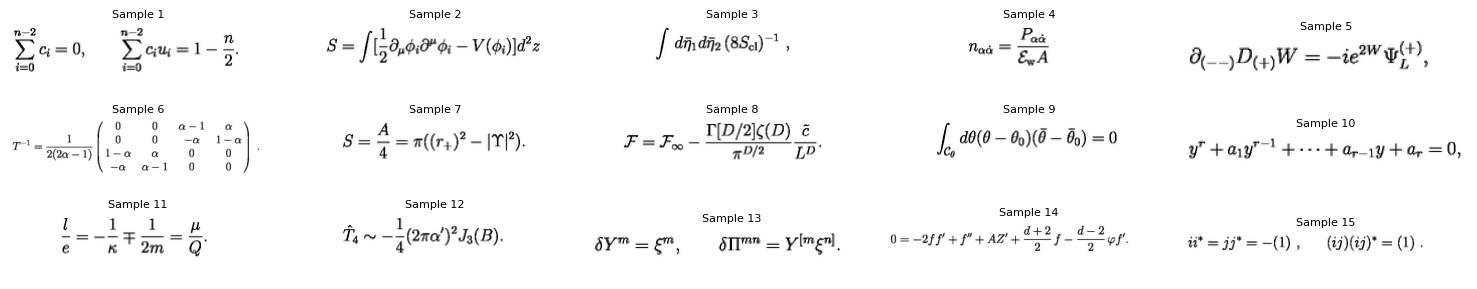

In [11]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def visualize(dataframe, dataset_dir, num_images=15):
    """
    Visualizes a subset of images from the dataset.

    Args:
        dataframe: The pandas DataFrame containing image paths and formulas.
        dataset_dir: The root directory containing the image files.
        num_images: Number of images to visualize.
    """
    plt.figure(figsize=(15, 3))

    # Select a subset of rows
    samples = dataframe.sample(n=num_images, random_state=42)

    for i, (_, sample) in enumerate(samples.iterrows()):
        plt.subplot(3, 5, i + 1)
        image_path = os.path.join(dataset_dir, sample['image'])  # Access image file path
        try:
            image = Image.open(image_path)  # Open the image using PIL
            plt.imshow(image, cmap='gray')  # Use grayscale if applicable
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            continue
        plt.axis('off')
        plt.title(f"Sample {i+1}", fontsize=8)  # Optional: show sample index or modify title

    plt.tight_layout()
    plt.show()

# Assuming train_df is your training DataFrame and images are in "images" subfolder
dataset_dir = "/content/im2latex100k/formula_images_processed/formula_images_processed"  # Update with your actual dataset directory
visualize(train_data, dataset_dir)


In [12]:
# import pandas as pd

# # Prepare training dataset
# train_df = pd.DataFrame({
#     'file_name': dataset['train']['filename'],  # Assuming 'filename' contains image filenames or paths
#     'text': kaggle_dataset['train']['formula']  # 'formula' contains the LaTeX expression
# })

# # Prepare testing dataset
# test_df = pd.DataFrame({
#     'file_name': kaggle_dataset['test']['filename'],  # Assuming 'filename' contains image filenames or paths
#     'text': kaggle_dataset['test']['formula']  # 'formula' contains the LaTeX expression
# })

# # Display dataset samples
# print("Training Dataset Sample:")
# print(train_data.head())

# print("Testing Dataset Sample:")
# print(test_data.head())


In [13]:
train_data.head()

,formula,image
0,\widetilde \gamma _ { \mathrm { h o p f } } \s...,66667cee5b.png
1,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...",1cbb05a562.png
2,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,ed164cc822.png
3,\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...,e265f9dc6b.png
4,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...",242a58bc3a.png


In [14]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Small random rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # Slight brightness and contrast adjustments
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomAffine(degrees=0, shear=5),  # Slight shear transformation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization (optional)
])


In [31]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer, max_target_length=128):
        """
        Custom dataset for OCR tasks.

        Args:
            root_dir (str): Directory containing the images.
            df (pd.DataFrame): DataFrame with 'image' and 'formula' columns.
            processor: Image processor (e.g., TrOCR processor).
            tokenizer: Text tokenizer (e.g., MathBERTa tokenizer).
            max_target_length (int): Maximum length for tokenized text.
        """
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            # Get image file name and formula
            file_name = self.df.iloc[idx]['image']
            text = str(self.df.iloc[idx]['formula']).strip()  # Ensure text is a string and strip whitespace

            if not text:  # Validate text
                raise ValueError(f"Formula at index {idx} is empty after stripping.")

            # Load and process image
            image_path = os.path.join(self.root_dir, file_name)
            image = Image.open(image_path).convert('RGB')
            image_features = self.processor(image, return_tensors="pt")
            pixel_values = image_features.pixel_values.squeeze(0)

            # Tokenize text and create labels
            text_encoding = self.tokenizer(
                text,
                padding='max_length',
                max_length=self.max_target_length,
                truncation=True,
                return_tensors="pt"
            )
            labels = text_encoding.input_ids.squeeze(0)
            labels[labels == self.tokenizer.pad_token_id] = -100  # Set padding tokens to -100

            return {
                "pixel_values": pixel_values,
                "labels": labels
            }

        except Exception as e:
            print(f"Error processing item at index {idx}: {str(e)}")
            print(f"File: {self.df.iloc[idx]['image']}, Formula: {self.df.iloc[idx]['formula']}")
            raise


class CustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        # First, separate the features
        pixel_values = [feature["pixel_values"] for feature in features]
        # input_ids = [feature["input_ids"] for feature in features]
        # attention_mask = [feature["attention_mask"] for feature in features]
        labels = [feature["labels"] for feature in features]

        # Stack tensors
        batch = {
            "pixel_values": torch.stack(pixel_values),


            # "input_ids": torch.stack(input_ids),
            # "attention_mask": torch.stack(attention_mask),
            "labels": torch.stack(labels)
        }

        return batch
#     "pixel_values": pixel_values,
#     "input_ids": input_ids,
#     "attention_mask": attention_mask,
#     "labels": labels
#
# Example usage demonstration
def create_and_test_dataset(dataset_dir, train_data, processor, tokenizer):
    # Create dataset
    dataset = CustomOCRDataset(
        root_dir=dataset_dir,
        df=train_data,
        processor=processor,
        tokenizer=tokenizer
    )

    # Create data collator
    collator = CustomDataCollator(tokenizer)

    # Test single item
    print("Testing single item from dataset:")
    sample = dataset[0]
    for key, value in sample.items():
        if isinstance(value, torch.Tensor):
            print(f"{key} shape:", value.shape)

    # Test batch collation
    from torch.utils.data import DataLoader
    loader = DataLoader(dataset, batch_size=4, collate_fn=collator)
    batch = next(iter(loader))

    print("\nTesting batch after collation:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            print(f"{key} shape:", value.shape)

    return dataset, collator

In [32]:
# Validation function to check dataset items
def validate_dataset(dataset, num_samples=5):
    print(f"Validating first {num_samples} items in dataset...")

    for i in range(min(num_samples, len(dataset))):
        try:
            item = dataset[i]
            print(f"\nItem {i}:")
            print(f"Pixel values shape: {item['pixel_values'].shape}")
            # print(f"Input IDs shape: {item['input_ids'].shape}")
            # print(f"Attention mask shape: {item['attention_mask'].shape}")
            print(f"Labels shape: {item['labels'].shape}")

            # Print original formula text
            original_text = str(dataset.df.iloc[i]['formula'])
            print(f"Original formula: {original_text[:50]}...")

        except Exception as e:
            print(f"Error validating item {i}: {str(e)}")
            raise

# Usage example:
def setup_training(dataset_dir, train_data, test_data, processor, tokenizer):
    # Create datasets
    train_dataset = CustomOCRDataset(
        root_dir=dataset_dir,
        df=train_data,
        processor=processor,
        tokenizer=tokenizer
    )

    valid_dataset = CustomOCRDataset(
        root_dir=dataset_dir,
        df=test_data,
        processor=processor,
        tokenizer=tokenizer
    )

    # Validate datasets
    print("Validating training dataset:")
    validate_dataset(train_dataset)
    print("\nValidating validation dataset:")
    validate_dataset(valid_dataset)

    # Create data collator
    data_collator = CustomDataCollator(tokenizer)

    return train_dataset, valid_dataset, data_collator

In [17]:
print(train_data.columns)



Index(['formula', 'image'], dtype='object')


In [33]:
# Initialize models and tokenizers
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
# tokenizer = AutoTokenizer.from_pretrained("witiko/mathberta")
tokenizer = processor.tokenizer
# Create and test datasets
train_dataset, valid_dataset, data_collator = setup_training(
    dataset_dir=dataset_dir,
    train_data=train_data,
    test_data=test_data,
    processor=processor,
    tokenizer=tokenizer
)


# Test dataset example - updated to show all returned fields
example = train_dataset[0]
print("Pixel values shape:", example['pixel_values'].shape)
print("Labels shape:", example['labels'].shape)
# print("Input IDs shape:", example['input_ids'].shape)
# print("Attention mask shape:", example['attention_mask'].shape)

Validating training dataset:
Validating first 5 items in dataset...

Item 0:
Pixel values shape: torch.Size([3, 384, 384])
Labels shape: torch.Size([128])
Original formula: \widetilde \gamma _ { \mathrm { h o p f } } \simeq...

Item 1:
Pixel values shape: torch.Size([3, 384, 384])
Labels shape: torch.Size([128])
Original formula: ( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \ \ (...

Item 2:
Pixel values shape: torch.Size([3, 384, 384])
Labels shape: torch.Size([128])
Original formula: S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ( 1 ...

Item 3:
Pixel values shape: torch.Size([3, 384, 384])
Labels shape: torch.Size([128])
Original formula: \hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a _ { ...

Item 4:
Pixel values shape: torch.Size([3, 384, 384])
Labels shape: torch.Size([128])
Original formula: \, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } d \p...

Validating validation dataset:
Validating first 5 items in dataset...

Item 0:
Pixel values shape: torch.Size([3, 384, 384])
Labels shap

In [19]:
len(train_dataset)

75275

In [20]:
len(valid_dataset)


10355

In [34]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [35]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

In [36]:
data_collator = CustomDataCollator(tokenizer=tokenizer)


In [37]:
# Load tokenizer and model for LaTeX data
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("witiko/mathberta")
# model = AutoModelForMaskedLM.from_pretrained("witiko/mathberta")


# Update the model configuration for decoding settings
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id

# Ensure the vocabulary size matches the tokenizer's vocab size
model.config.vocab_size = len(tokenizer)

# Set decoding hyperparameters
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
print(model.config)

VisionEncoderDecoderConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "microsoft/trocr-base-printed",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_attn_implementation_autoset": false,
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 768,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 12,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "fin

In [38]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [39]:
cer_metric = evaluate.load('cer')


def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions


    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)


    cer = cer_metric.compute(predictions=pred_str, references=label_str)


    return {"cer": cer}

In [58]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",  # Evaluate after a set number of steps
    save_strategy="steps",        # Save after the same number of steps
    eval_steps=500,               # Perform evaluation every 500 steps
    save_steps=500,               # Save the model every 500 steps
    load_best_model_at_end=True,  # Load the best model at the end
    per_device_train_batch_size=10,  # Reduce batch size to save memory
    per_device_eval_batch_size=10,
    num_train_epochs=3,
    output_dir="./results",
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,  # Limit the number of saved checkpoints
    fp16=True,  # Use mixed precision training
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-59-53a006598497>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
res = trainer.train()

Step,Training Loss,Validation Loss
500,3.208900,3.214692
1000,2.970100,3.071295
1500,2.854400,2.943905
2000,2.771400,2.866012
2500,2.741800,3.186328


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [53]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
!nvidia-smi


Fri Nov 22 13:07:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              29W /  70W |  15065MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Model config vocab size:", model.config.vocab_size)
print("Pad token ID:", tokenizer.pad_token_id)


Tokenizer vocab size: 64002


AttributeError: 'VisionEncoderDecoderConfig' object has no attribute 'vocab_size'

In [ ]:
# Define a directory to save the model
output_dir = "./saved_model"

# Save the model
model.save_pretrained(output_dir)

# Save the processor (used for pre/post-processing)
processor.save_pretrained(output_dir)

print(f"Model and processor saved to {output_dir}")


In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

# Load the model
model = VisionEncoderDecoderModel.from_pretrained(output_dir)

# Load the processor
processor = TrOCRProcessor.from_pretrained(output_dir)

print("Model and processor successfully loaded.")
